In [1]:
# CAN JUST RUN THE WHOLE NOTEBOOK AT ONCE
# 
# Calculating frequency spectrum and power per each frequency band.

import os

#import matplotlib
#matplotlib.use('MACOSX')
#for some reason if I run these 2 lines - it doesnt plot at all any more.

import numpy as np
import mne
import matplotlib.pyplot as plt
from copy import deepcopy
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

In [2]:
#sample_data_folder = mne.datasets.sample.data_path()
#kath_raw_file2 = "/Users/jenya/Documents/Oldenburg and university/Job Uni Rieger lab/Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif"
kath_raw_file = os.path.join('Katharinas_Data','sub_HT05ND16', '210811', 'mikado-1.fif')

#print(kath_raw_file)
#print(kath_raw_file2)                                   
raw = mne.io.read_raw_fif(kath_raw_file)
#raw.crop(0, 60).load_data()  # just use a fraction of data for speed here

#Print info about the data:
#print(raw)
#print(raw.info)
raw

Opening raw data file Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif...


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_62114/2064368720.py:7: RuntimeWarning: This filename (Katharinas_Data/sub_HT05ND16/210811/mikado-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(kath_raw_file)


    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Katharinas_Data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 

<Raw | mikado-1.fif, 319 x 3390000 (3390.0 s), ~6.6 MB, data not loaded>

Reading 0 ... 3389999  =      0.000 ...  3389.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


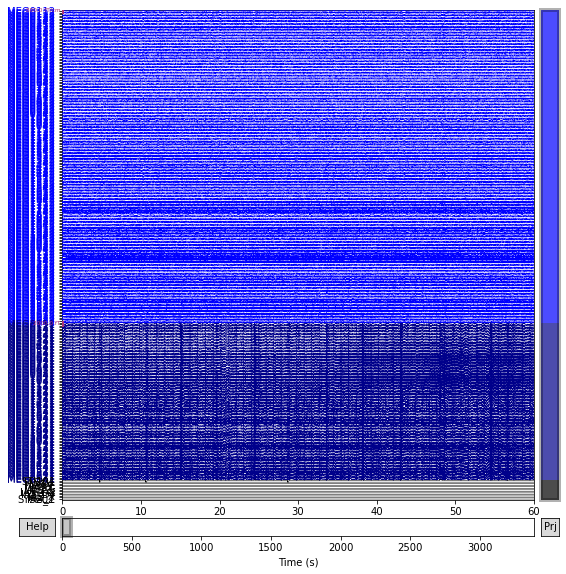

In [3]:
# Filtering the data: 0.5-100Hz bandpass:
# Upper level: No useful brain info comes over 100Hz
# Lower level: maybe better from 0.5 because delta frequency is 0.5-4Hz? 
# (needed for frequency spectrum) and we cut it now. 
# But we do 1-100Hz for now.
# Question: does this filtering change the magnitude of stds? from 9 to 12-13? Later we see that no.

# I m using here the Butterworth filter similar to filtfilt in matlab, like we  
# did in the course with eeg data. such filter creates no time shift, since it filters forward and backward.
# But we might use a different filter as well. I dont know if this one is the best possible option.

#raw.crop(0, 60)

raw.load_data(verbose=True)
raw_bandpass = raw.copy()
raw_bandpass.filter(l_freq=0.5, h_freq=100, picks='meg', method='iir', iir_params=None, verbose=True)

# "if method=”iir”, 4th order Butterworth will be used" BUT it used filter order 16 here. and why is that???

#Plot first 60 seconds of the filtered data:
#(remove_dc=False) is copied from tutiril. I dont get what it means? No explanation in documentation.
fig = raw_bandpass.plot(duration=60, proj=False, n_channels=len(raw_bandpass.ch_names), remove_dc=False, verbose=True)

In [4]:
# Frequency spectrum using Welch method:

picks_grad = mne.pick_types(raw_bandpass.info, meg='grad', eeg=False, eog=False, stim=False)
picks_magn = mne.pick_types(raw_bandpass.info, meg='mag', eeg=False, eog=False, stim=False)

psds_mags, freqs_mags = psd_welch(raw_bandpass, fmin=0, fmax=200, n_jobs=-1, picks=picks_magn, n_fft=1000, n_per_seg=1000, tmin=None, tmax=None)
psds_grads, freqs_grads = psd_welch(raw_bandpass, fmin=0, fmax=200, n_jobs=-1, picks=picks_grad, n_fft=1000, n_per_seg=1000, tmin=None, tmax=None)
#CALCULATES NOW OVER ALL TIME. SET TIME HERE IF WANT IT FASTER OR PARTICULAR PERIOD. RESULT CAN LOOK VERY DIFFERNT.

# n_per_seg - Length of each Welch segment (windowed with a Hamming window). Defaults to None, which sets n_per_seg equal to n_fft.
# n_fft - The length of FFT used, must be >= n_per_seg (default: 256). The segments will be zero-padded if n_fft > n_per_seg. If n_per_seg 
# is None, n_fft must be <= number of time points in the data.
# These influence the bandwidth.

# ? Understandable explanation of parameters to be put here :)


Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    9.4s remaining:   15.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   12.7s remaining:    7.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   15.7s finished


Effective window size : 1.000 (s)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:   17.9s remaining:   29.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:   26.4s remaining:   15.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   36.6s finished


In [5]:
freqs_mat_mags=np.tile(freqs_mags, [np.shape(psds_mags)[0],1])
freqs_mat_grads=np.tile(freqs_grads, [np.shape(psds_grads)[0],1])

from matplotlib import pyplot as plt

%matplotlib qt
#%matplotlib inline

#Magnetometers:
plt.figure()
plt.plot(freqs_mat_mags.T, np.sqrt(psds_mags.T))
plt.yscale='log'
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (T / Hz)')  #check the units!
plt.title("Welch's periodogram for all magnetometers")
plt.show()

#Freq spectrum peaks we see (visible on shorter interval, not so much when Welch is done over all time:
#50, 100, 150 - powerline EU
#6 noise of shielding chambers 
#44 meg noise
#17 - was it the train station near by?
#10 Secret :)
#1hz - highpass filter.
#flat spectrum is white noise process. Has same energy in every frequency (starts around 50Hz or even below)

#Gradiometers:
plt.figure()
plt.plot(freqs_mat_grads.T, np.sqrt(psds_grads.T))
plt.yscale='log'
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (T/m)²/Hz)')  #check the units!
plt.title("Welch's periodogram for all gradiometers")
plt.show()

#Need to find frequencies.. and filter out? 
#Powerline
#Eye moves 
#Blinks
#Cardio: try to autocreate it. Maybe it s small enough to not care?
#Muscle movements 



qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


In [6]:
#For frequency spectrum do we need to estimate for the entire duration or just per epoch?

#What we did in course:
#Filter the whole data bandpass: 0.3-200 Hz -  frequencies we r inetersted in
#cutting out separate epochs. so he have data as: channel*epoch of particular duration
#calculate frequency spectrum (seems for the entire duration. why did we cut then?)

#__________________
# What we do here:
# Take 1 band, delta or so and calculate area under the curve. 
# Or: take one band and calculate std
# Devide area under curve by num of freq. Should be same as rmse for this band.

# Bands info: https://raphaelvallat.com/bandpower.html
# delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz).
# Code adopted from the bands article above:

#THIS CELL CALCULATES ONLY FOR channel#2 (indexed as 1) in grads AND PLOTS THE RESULT:
#Use this cell to check the results of the next cell!

from scipy.integrate import simps

wave_bands=[[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]

for w in wave_bands:

    # Define delta lower and upper limits
    low, high = w

    # Find intersecting values in frequency vector

    # Take just 1 channel for now:
    # idx_delta = np.logical_and(freqs >= low, freqs <= high)

    idx_delta_grads = np.logical_and(freqs_grads >= low, freqs_grads <= high)

    psd_ch1=psds_grads[1, :]

    # Plot the power spectral density and fill the delta area
    plt.figure(figsize=(7, 4))
    plt.plot(freqs_grads, psd_ch1, lw=2, color='k')
    plt.fill_between(freqs_grads, psd_ch1, where=idx_delta_grads, color='skyblue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (uV^2 / Hz)')
    plt.xlim([0, 100])
    plt.ylim([0, psd_ch1.max() * 1.1])
    plt.title("Welch's periodogram")
    plt.show()

    #Area under the curve

    # Frequency resolution
    freq_res = freqs_grads[1] - freqs_grads[0]  # = 1 / 4 = 0.25

    # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd_ch1[idx_delta_grads], dx=freq_res)
    print('Absolute power of this band in V^2: ', delta_power)

    total_power = simps(psd_ch1, dx=freq_res)
    delta_rel_power = delta_power / total_power
    print('Relative power: %.3f' % delta_rel_power)

    #delta_compare=delta_power/len(idx_delta_mags==True) #devide the power by the  number of frequencies in the band

    delta_compare=delta_power/sum(idx_delta_grads)
    print('Power per frequency (to compare with RMSE): ', delta_compare) #HOW TO NAME THIS VALUE?

#The units of the power spectral density, when working with EEG data, is usually micro-Volts-squared per Hz



Absolute power of this band in V^2:  6.468795051935186e-17
Relative power: 0.053
Power per frequency (to compare with RMSE):  1.6171987629837965e-17
Absolute power of this band in V^2:  6.320413040878318e-17
Relative power: 0.052
Power per frequency (to compare with RMSE):  1.2640826081756636e-17
Absolute power of this band in V^2:  6.305563290562374e-17
Relative power: 0.052
Power per frequency (to compare with RMSE):  1.2611126581124748e-17
Absolute power of this band in V^2:  2.981019442801916e-16
Relative power: 0.244
Power per frequency (to compare with RMSE):  1.5689576014746925e-17
Absolute power of this band in V^2:  6.820428417199857e-16
Relative power: 0.558
Power per frequency (to compare with RMSE):  9.606237207323742e-18


In [7]:
# Power calculation for all mags + grads channels separately, 
# saving power + power/freq value in data frames.

from scipy.integrate import simps
import pandas as pd

#Separate mags and grads:
mags = [(chs['ch_name'], i) for i, chs in enumerate(raw_bandpass.info['chs']) if str(chs['unit']).endswith('UNIT_T)')]
grads = [(chs['ch_name'], i) for i, chs in enumerate(raw_bandpass.info['chs']) if str(chs['unit']).endswith('UNIT_T_M)')]

# Calculate the band power:
wave_bands=[[0.5, 4], [4, 8], [8, 12], [12, 30], [30, 100]]
#delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), beta (12–30 Hz), and gamma (30–100 Hz) bands

mags_names = [mag[0] for mag in mags]
grads_names = [grad[0] for grad in grads]

dict_mags_power = {}
dict_grads_power = {}

dict_mags_power_freq = {}
dict_grads_power_freq = {}

dict_mags_rel_power = {}
dict_grads_rel_power = {}

for w in enumerate(wave_bands): #loop over bands

    low, high = w[1] # Define delta lower and upper limits
    power_per_band = {"mags": [], "grads": []}
    power_per_freq_per_band = {"mags": [], "grads": []}
    rel_power_per_band = {"mags": [], "grads": []}

  #loop over mags, then grads

    idx_delta_m = np.logical_and(freqs_mags >= low, freqs_mags <= high)
    for m in enumerate(psds_mags): 
    #loop over mags channels. psd_ch_m is psd of partigular channel

        ch_name_m=mags_names[m[0]]
        psd_ch_m=np.array(m[1])

        #Area under the curve:
        # Frequency resolution
        freq_res = freqs_mags[1] - freqs_mags[0]  # = 1 / 4 = 0.25

        # Compute the absolute power by approximating the area under the curve
        band_power_m = simps(psd_ch_m[idx_delta_m], dx=freq_res)

        #devide the power by the  number of frequencies in the band
        power_compare_m=band_power_m/sum(idx_delta_m) 

        #calculate the relative power: % of this band in the total bands power for this channel:
        total_power_m = simps(psd_ch_m, dx=freq_res)
        band_rel_power_m = band_power_m / total_power_m

        power_per_band['mags'].append(band_power_m)
        rel_power_per_band['mags'].append(band_rel_power_m)
        power_per_freq_per_band['mags'].append(power_compare_m)

    #print('mags done')

    idx_delta_g = np.logical_and(freqs_grads >= low, freqs_grads <= high)
    for g in enumerate(psds_grads): 
    #loop over grads channels and their names

        ch_name_g=grads_names[g[0]]
        psd_ch_g=np.array(g[1])

        #Area under the curve:
        # Frequency resolution
        freq_res = freqs_grads[1] - freqs_grads[0]  

        # Compute the absolute power by approximating the area under the curve
        band_power_g = simps(psd_ch_g[idx_delta_g], dx=freq_res)

        #devide the power by the  number of frequencies in the band
        power_compare_g=band_power_g/sum(idx_delta_g) 

        #calculate the relative power: % of this band in the total bands power for this channel:
        total_power_g = simps(psd_ch_g, dx=freq_res)
        band_rel_power_g = band_power_g / total_power_g

        power_per_band['grads'].append(band_power_g)
        rel_power_per_band['grads'].append(band_rel_power_g)
        power_per_freq_per_band['grads'].append(power_compare_g)

    #print('grads done')

        
    dict_mags_power[w[0]] = power_per_band["mags"]
    dict_grads_power[w[0]] = power_per_band["grads"]

    dict_mags_power_freq[w[0]] = power_per_freq_per_band["mags"]
    dict_grads_power_freq[w[0]] = power_per_freq_per_band["grads"]

    dict_mags_rel_power[w[0]] = rel_power_per_band["mags"]
    dict_grads_rel_power[w[0]] = rel_power_per_band["grads"]


# Save power and delta_compare to data frame:
df_power_mags = pd.DataFrame(dict_mags_power, index=mags_names)
df_power_grads = pd.DataFrame(dict_grads_power, index=grads_names)

df_power_freq_mags = pd.DataFrame(dict_mags_power_freq, index=mags_names)
df_power_freq_grads = pd.DataFrame(dict_grads_power_freq, index=grads_names)

df_rel_power_mags = pd.DataFrame(dict_mags_rel_power, index=mags_names)
df_rel_power_grads = pd.DataFrame(dict_grads_rel_power, index=grads_names)


In [8]:
# Rename columns and extract to csv:

renamed_df_power_mags = df_power_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
renamed_df_power_grads = df_power_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

renamed_df_power_freq_mags = df_power_freq_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
renamed_df_power_freq_grads = df_power_freq_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

renamed_df_rel_power_mags = df_rel_power_mags.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})
renamed_df_rel_power_grads = df_rel_power_grads.rename(columns={0: "delta (0.5-4 Hz)", 1: "theta (4-8 Hz)", 2: "alpha (8-12 Hz)", 3: "beta (12-30 Hz)", 4: "gamma (30-100 Hz)"})

renamed_df_power_mags.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/abs_power_mags.csv')
renamed_df_power_grads.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/abs_power_grads.csv')

renamed_df_power_freq_mags.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/power_per_freq_mags.csv')
renamed_df_power_freq_grads.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/power_per_freq_grads.csv')

renamed_df_rel_power_mags.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/relative_power_mags.csv')
renamed_df_rel_power_grads.to_csv('/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/relative_power_grads.csv')

#Look at df:
renamed_df_rel_power_mags
     

,delta (0.5-4 Hz),theta (4-8 Hz),alpha (8-12 Hz),beta (12-30 Hz),gamma (30-100 Hz)
MEG0111,0.000591,0.001337,0.002983,0.054109,0.894758
MEG0121,0.075980,0.074488,0.072293,0.295161,0.421623
MEG0131,0.032851,0.033364,0.033910,0.172682,0.677883
MEG0141,0.007060,0.008596,0.011034,0.106611,0.851187
MEG0211,0.000269,0.001478,0.003832,0.074453,0.845315
...,...,...,...,...,...
MEG2541,0.000742,0.001451,0.003046,0.052998,0.885925
MEG2611,0.007960,0.008979,0.010504,0.085391,0.846383
MEG2621,0.034650,0.033847,0.034279,0.175634,0.683086
MEG2631,0.065741,0.064357,0.062247,0.249993,0.478485


In [9]:
# Might be useful: visual or some calculation for all channel to see which band in which channel 
# might be too strong/weak? Can be done as color plot. (But way too many channels, might be hard to see). 
# Or some calculation like 1 std or so.. 


In [10]:
#Calculate power per band over all mags and all grads

import statistics 

power_dfs=[df_power_mags, df_rel_power_mags, df_power_grads, df_rel_power_grads, df_power_freq_mags, df_power_freq_grads]
#keep them in this order!  important for this cell calculations

bands_names=['delta', 'theta', 'alpha', 'beta', 'gamma']
band_title=['Magnetometers. Average absolute power per band:', 'Magnetometers. Average relative power per band:',
'Gradiometers. Average absolute power per band:', 'Gradiometers. Average relative power per band:', 
'Magnetometers. Average power/freq per band:', 'Gradiometers. Average power/freq per band:']

mean_abs_m=[]
mean_abs_g=[]
mean_relative_m=[]
mean_relative_g=[]
mean_power_nfreq_m=[]
mean_power_nfreq_g=[]

for d in enumerate(power_dfs):
    print(band_title[d[0]])

    for w in enumerate(bands_names): #loop over bands
        mean_power_per_band = statistics.mean(d[1].loc[:,w[0]])
        
        if d[0]==0: #df_power_mags:
            mean_abs_m.append(mean_power_per_band) 
        elif d[0]==1: #df_rel_power_mags:
            mean_relative_m.append(mean_power_per_band) 
        elif d[0]==2: #df_power_grads:
            mean_abs_g.append(mean_power_per_band)
        elif d[0]==3: #df_rel_power_grads:
            mean_relative_g.append(mean_power_per_band) 
        elif d[0]==4: #df_power_freq_mags:
            mean_power_nfreq_m.append(mean_power_per_band)
        elif d[0]==5: #df_power_freq_grads:
            mean_power_nfreq_g.append(mean_power_per_band)
        print(w[1], mean_power_per_band)


    
#Should probably extract this info in a file? what kind of file?


#Visual: band power over all mags and grads as a pie chart:

#The mean relative percentages dont sum up into 100%, so added the 'unknown' part.

bands_names_un=['delta', 'theta', 'alpha', 'beta', 'gamma', 'unknown']

mean_relative_m_un=[v * 100 for v in mean_relative_m]  #in percentage
mean_relative_m_un.append(100-(sum(mean_relative_m))*100)
mean_relative_g_un=[v * 100 for v in mean_relative_g] #in percentage
mean_relative_g_un.append(100-(sum(mean_relative_g))*100)

fig1, axs = plt.subplots(1,2)
fig1.suptitle('Relative power of each band')
axs[0].pie(mean_relative_m_un, labels=bands_names_un, autopct='%1.1f%%') #autopct for percentage values
axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title('Magnetometers')
axs[1].pie(mean_relative_g_un, labels=bands_names_un, autopct='%1.1f%%')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[1].set_title('Gradiometers')
plt.show()


# Plot shows:
# - very diffrerent relative power of some bands on mags and grads if choose some short time frame during welch. why is that?
# - if take whole time - grads and mags are more similar, but gamma power is way too much.
# - unknown frequencies about 6-7% overall. where do they come from? Ther data is already filtered at 0.5-100Hz. 
# Maybe these are the non-perfectly extracted during fft frequencies and during non-perfect filtering? 

#I should probably calculate this differently? Not mean over each separate channel, but absolute of each band over all data, and then relative from it?
#But how? The psd calculates for every channel individually. Hence, the power of bands for every channels separately as well.



Magnetometers. Average absolute power per band:
delta 3.181406077746226e-20
theta 3.1511680777525584e-20
alpha 3.1341973647165964e-20
beta 1.4651243951548246e-19
gamma 5.390479016765559e-19
Magnetometers. Average relative power per band:
delta 0.03389610544717461
theta 0.033569929383074265
alpha 0.03343698559387611
beta 0.15786570179570192
gamma 0.6752513409581824
Gradiometers. Average absolute power per band:
delta 2.0644963129386703e-16
theta 2.0303382896628492e-16
alpha 2.0025245874674509e-16
beta 8.981227124415387e-16
gamma 2.7907677748437115e-15
Gradiometers. Average relative power per band:
delta 0.0428516009646623
theta 0.042064436243977384
alpha 0.041439098926894485
beta 0.18505734710150804
gamma 0.6182068812769267
Magnetometers. Average power/freq per band:
delta 7.953515194365565e-21
theta 6.3023361555051166e-21
alpha 6.268394729433193e-21
beta 7.711181027130655e-21
gamma 7.592223967275436e-21
Gradiometers. Average power/freq per band:
delta 5.1612407823466756e-17
theta 4.060

In [11]:
# Write bandpower function like in the article above, but usong mne instead of signal processing toolbox?



In [12]:
# Finding peaks?
# 
# https://mne.tools/stable/generated/mne.preprocessing.peak_finder.html?highlight=peak

In [13]:
# Turn it into a function/module